## Informe Trabajo Práctico 3

#### Rapoport Juana

### Introducción

El presente informe tiene como objetivo principal acceder y analizar estadísticamente grandes conjuntos de datos observacionales mediante el uso de bases de datos y el lenguaje Structured Query Language (SQL). Las bases de datos permiten almacenar de manera sistemática grandes volúmenes de información pertenecientes a un contexto específico. A través de consultas SQL, es posible extraer subconjuntos de datos que comparten ciertas características, organizándolos en estructuras denominadas Tablas.

Cada tabla está compuesta por dos elementos fundamentales: Campos y Registros. Los Campos representan la unidad mínima de información, correspondiendo a una característica particular, como puede ser la masa de un objeto, su distancia, tipo espectral, entre otras, y se organizan en columnas. Por otro lado, cada fila de la tabla constituye un Registro, el cual contiene las características de un objeto individual, formando una unidad de datos única y estructurada.

En este análisis se utiliza el catálogo de exoplanetas disponible en la base de datos exoplanets.eu, con el propósito de estudiar algunas de las principales características de estos sistemas, tales como la masa, el radio, el período orbital, entre otras. En particular, se examina la distribución de masas y períodos orbitales de los exoplanetas descubiertos mediante diferentes técnicas observacionales. Además, se evalúa si la distribución de las distancias a las estrellas anfitrionas sigue un comportamiento gaussiano o no. Finalmente, se propone un modelo que relaciona la masa con el radio de los exoplanetas, y se lleva a cabo un ajuste del modelo para explorar dicha relación.


Se instala el paquete pyvo necesario para acceder a la base de datos (de manera remota) y hacer el query para obtener una tabla con los datos de interes. Se realiza un query de prueba.

In [1]:
pip install pyvo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.9/912.9 kB 1.8 MB/s eta 0:00:00


In [2]:
# Librerías
import pyvo as vo
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
# Se desea obtener una tabla/lista de exoplanetas con las siguientes propiedades: Masa, Periodo Orbital, Tipo de Estrella del Sistema.

# Definimos el servicio desde el cual se obtendrán los datos de exoplanetas
service = vo.dal.TAPService("http://voparis-tap-planeto.obspm.fr/tap")

# Definimos el query SQL para obtener los datos de interés: nombre del exoplaneta, masa, periodo orbital y tipo espectral de la estrella
query = """
    SELECT target_name, mass, period, star_spec_type
    FROM exoplanet.epn_core
    WHERE mass IS NOT NULL
    AND period IS NOT NULL
    AND star_spec_type IS NOT NULL
"""

# Ejecutamos la consulta y obtenemos los resultados
try:
    results = service.search(query)
    print("Consulta realizada con éxito.")
except Exception as e:
    print(f"Error al ejecutar la consulta: {e}")
    exit()

# Convertimos los resultados a una tabla de Astropy para su manejo
table = results.to_table()

# Convertimos la tabla de Astropy a un DataFrame de pandas para un análisis más sencillo
df = table.to_pandas()

# Guardamos los datos en un archivo XML local (formato VOTable)
try:
    votable = results.votable
    votable.to_xml("Exoplanets_Data.xml")
    print("Datos guardados en Exoplanets_Data.xml.")
except Exception as e:
    print(f"Error al guardar los datos en XML: {e}")

# Mostramos los primeros registros de la tabla para verificar los datos
print(df.head())

Consulta realizada con éxito.
Datos guardados en Exoplanets_Data.xml.
  target_name     mass    period star_spec_type
0   109 Psc b   5.7430   1075.40          G5 IV
1   112 Psc b   0.0330      4.40           G0IV
2   112 Psc c   9.8660  36336.70           G0IV
3   11 Com Ab  16.1284    326.03          G8III
4    11 UMi b  11.0873    516.22          K4III


#### Ejercicio 6: Distribución de Masas y Períodos Orbitales

Se examina las distribucions de masas y periodos orbitales de exoplanetas, detectados con las siguientes tecnicas observacionles: Imaging, Radial Velocity, Microlensing, Primary Transit, Astrometry, Transit Timing Variation (TTV) y Pulsar. Se intenta determinar si la tecnica utilizada introduce un sesgo las caracteristicas de los exoplanetas detectados.


No hay planetas detectados por Timing


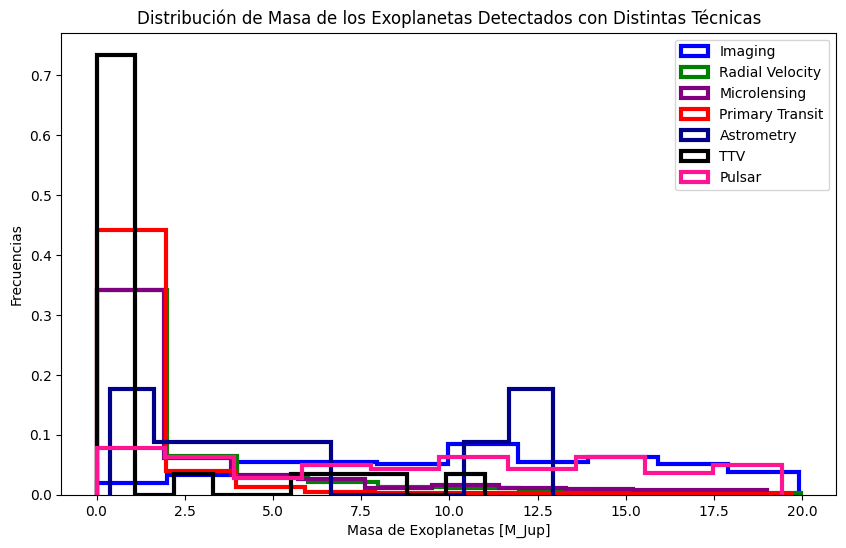

In [6]:
# Función para realizar las consultas y obtener los datos de masa
def query_exoplanets(detection_type, max_mass=20):
    query = f"SELECT target_name, detection_type, mass, period FROM exoplanet.epn_core WHERE detection_type='{detection_type}' and mass<{max_mass}"
    result = service.search(query)
    table = result.to_table()
    return table.to_pandas()

# Inicialización del servicio
service = vo.dal.TAPService("http://voparis-tap-planeto.obspm.fr/tap")

# Listado de técnicas de detección y sus configuraciones de colores para el gráfico
detection_methods = {
    'Imaging': {'color': 'blue', 'label': 'Imaging'},
    'Radial Velocity': {'color': 'green', 'label': 'Radial Velocity'},
    'Timing': {'color': 'orange', 'label': 'Timing'},
    'Microlensing': {'color': 'purple', 'label': 'Microlensing'},
    'Primary Transit': {'color': 'red', 'label': 'Primary Transit'},
    'Astrometry': {'color': 'darkblue', 'label': 'Astrometry'},
    'TTV': {'color': 'black', 'label': 'TTV'},
    'Pulsar': {'color': 'deeppink', 'label': 'Pulsar'}
}

# Iteramos sobre cada técnica de detección para obtener los datos y graficarlos
plt.figure(figsize=(10, 6))
for method, properties in detection_methods.items():
    data = query_exoplanets(method)
    if data.empty:
        print(f"No hay planetas detectados por {method}")
        continue

    masses = data['mass']
    plt.hist(masses, density=True, histtype='step', lw=3, color=properties['color'], label=properties['label'])

# Configuración del gráfico
plt.xlabel('Masa de Exoplanetas [M_Jup]')
plt.ylabel('Frecuencias')
plt.legend()
plt.title('Distribución de Masa de los Exoplanetas Detectados con Distintas Técnicas')
plt.show()


No hay datos de periodo para Timing.


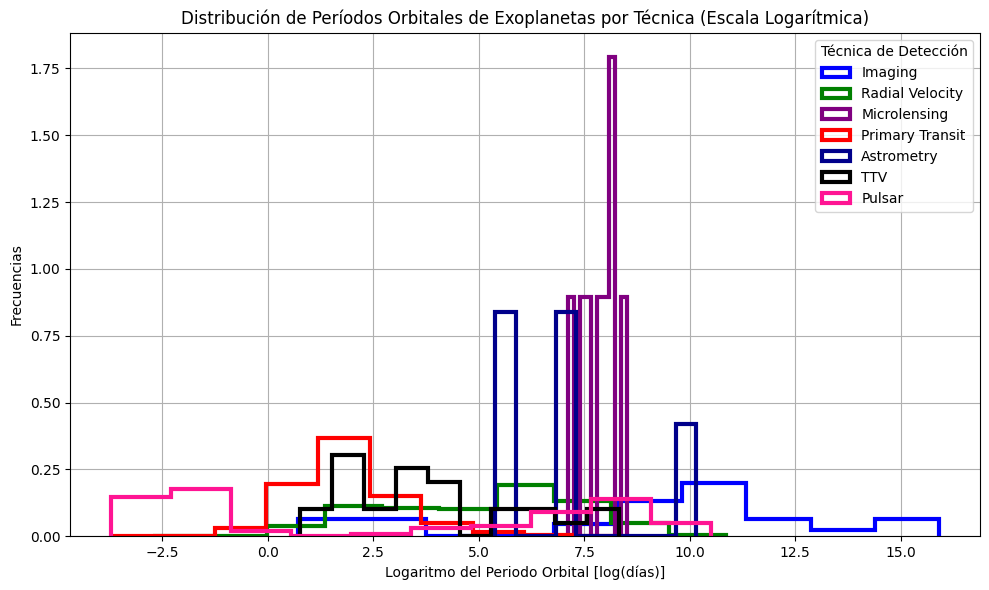

In [10]:
# Función para calcular el logaritmo de los periodos evitando valores nulos o no definidos
def get_log_period(data, method):
    period_data = data['period'].dropna()  # Elimina valores nulos
    if period_data.empty:
        print(f'No hay datos de periodo para {method}.')
        return None
    return np.log(period_data)


# Graficar los periodos orbitales en escala logarítmica
plt.figure(figsize=(10, 6))

for method, properties in detection_methods.items():
    data = query_exoplanets(method)
    log_periods = get_log_period(data, method)
    if log_periods is not None:  # Solo grafica si hay datos válidos
        plt.hist(log_periods, density=True, histtype='step', lw=3,
                 color=properties['color'], label=properties['label'])

# Etiquetas y leyenda
plt.xlabel('Logaritmo del Periodo Orbital [log(días)]')
plt.ylabel('Frecuencias')
plt.legend(title='Técnica de Detección')
plt.title('Distribución de Períodos Orbitales de Exoplanetas por Técnica (Escala Logarítmica)')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Ejercicio 7: Distribución de Distancias a Estrellas con Exoplanetas

A continuacion, se busca determinar si la distribucion de semiejes mayores de las orbitas de los exoplanetas es consistente con una distribucion (teorica) Gaussiana. Para esto se utilizara el Metodo Kolmogorv-Smirnov para una muestra, (one-sample KS test). Este metodo consiste en estabalecer una hipotesis nula y alternativa, en este caso serian:

Hipotesis Nula: $\ H_0=$  La muestra empirica sigue una distribucion Gaussiana con un nivel de significancia $\alpha=0.05$

Hipotesis Alternativa: $\ H_a=$  La muestra no procede de una distribucion Gaussiana con un nivel de significancia $\alpha=0.05$

Luego se calcula un estadistico definido como :
$$D=max |F_{1}(x)-F_{2}(x)|\\ x\in I$$

$0 ≤ D ≤ 1$; donde $I$ es algun intervalo y $F_{1}(x)$ y $F_{2}(x)$ son las funciones acumuladas de la distribucion empirica y  Gaussiana respectivamente. Es decir que se calcula la distancia maxima que existe entre ambas funciones para algun $x_i$ y se compara ese valor con otro valor de referencia, el cual depende de los grados de libertad $n$ y el nivel de significancia $\alpha$. Si el estadistico calculado supera el valor de referencia, entonces es poco probable (para el nivel de significancia dado) que la muestra siga la distribucion teorica establecida en la hipotesis nula.

$$ Zona\,\,de\,\,aceptacion: D < D_{KS,\alpha;n}\\ $$
$$ Zona\,\,de\,\,rechazo: D \geq D_{KS,\alpha;n}\\ $$

Ademas, se puede utilizar el valor-p o p-value que provee este metodo:

$$ Zona\,\,de\,\,aceptacion: p-value > \alpha \\ $$
$$ Zona\,\,de\,\,rechazo: p-value \leq \alpha \\ $$

Estadístico KS: 0.5003327178232841, p-valor: 0.0


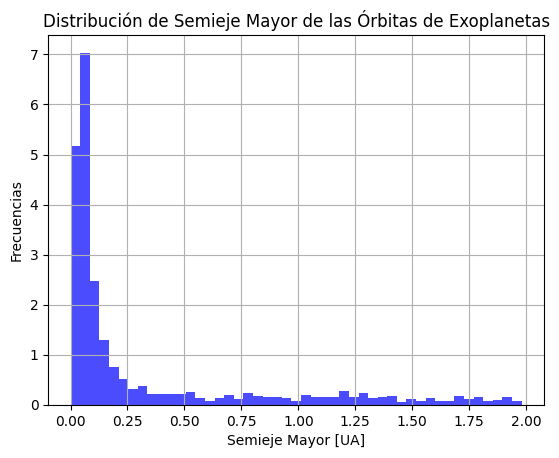

In [11]:
# Obtener los semiejes mayores (UA)
query = "SELECT target_name, semi_major_axis FROM exoplanet.epn_core WHERE mass < 20"
major_axis = service.search(query)  # Obtener una tabla con los datos del query
table = major_axis.to_table()  # Convertir a una tabla de Astropy
data = table.to_pandas()  # Transformar en un DataFrame de Pandas

# Realizar un Inner Join
exo_axis = pd.merge(left=data, right=data, how='inner', on='target_name')

# Filtrar semiejes mayores válidos
valid_distances = data['semi_major_axis'].dropna()  # Eliminar NaN
semi_major_axes = valid_distances[valid_distances < 2]  # Filtrar semiejes menores a 2 UA

# Graficar el histograma de los semiejes mayores
plt.hist(semi_major_axes, bins='auto', density=True, alpha=0.7, color='blue')
plt.xlabel('Semieje Mayor [UA]')
plt.ylabel('Frecuencias')
plt.title('Distribución de Semieje Mayor de las Órbitas de Exoplanetas')
plt.grid()

# Prueba de Kolmogorov-Smirnov para comparar con la distribución normal
ks_statistic, p_value = sp.kstest(semi_major_axes, 'norm')
print(f'Estadístico KS: {ks_statistic}, p-valor: {p_value}')


Se obtiene como resultado $D = 0.5003327178232841 $ y $p-value = 0$, dado que $p-value < \alpha$, se rechaza la hipotesis nula, es decir que no se tiene suficiente evidencia para concluir que las distancias a las estrellas con exoplanetas sigue una distribucion Gaussiana.

### Ejercicio 8: Relacion Masa versus Radio de Exoplanetas

EL objetivo de este ejercicio es buscar una relacion entre la masa y el radio de exoplanetas, para luego proponer y ajustar un modelo que reproduzca dicha relacion.

Para esto se se grafican los pares $ (\,\log(M) ; \log(R)\,) $ y se propone una ley de potencias para la relacion entre la masa y el radio:

$$ M(R) = \beta R^\alpha $$   Con lo cual se tiene que:

$$ log(M) = \alpha \log(R) + \log(\beta) $$
Es decir que basta realizar un ajuste lineal de la forma $$ y = A x + Β $$
donde $ A = \alpha\,\,$ y $\,\,Β = \log(\beta) $.

Por lo tanto, se ajusta una recta a los pares de puntos graficados para obtener los parametros del modelo $\alpha$ y $\beta$.

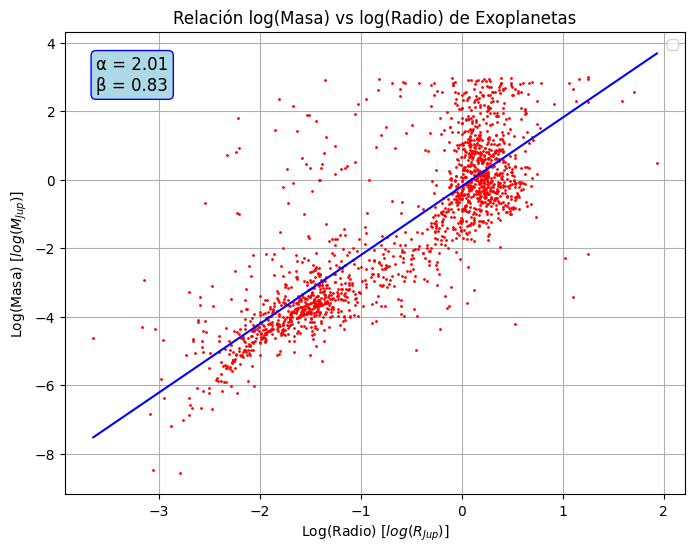

In [15]:
# Obtener masas y radios de los exoplanetas
query10 = "SELECT target_name, mass, radius FROM exoplanet.epn_core WHERE mass < 20"
results_10 = service.search(query10)  # Realiza la consulta
table10 = results_10.to_table()  # Convierte el resultado en una 'astropy table'
data10 = table10.to_pandas()  # Convierte la tabla en un DataFrame de pandas

# Realizar Inner Join para combinar datos
exo_mr = pd.merge(left=data10, right=exo_axis, how='inner', on='target_name')
exo_mr.to_csv('Exoplanets_Data.csv', index=False)  # Guardar datos en un CSV

# Filtrar datos asegurando que no haya valores NaN
query11 = "SELECT target_name, mass, radius FROM exoplanet.epn_core WHERE mass < 20 AND mass != 'Nan' AND radius != 'Nan'"
results_11 = service.search(query11)  # Realiza la consulta
table11 = results_11.to_table()  # Convierte el resultado en una 'astropy table'
data11 = table11.to_pandas()  # Convierte la tabla en un DataFrame de pandas

# Calcular logaritmos de masa y radio
m = np.log(data11['mass'])
r = np.log(data11['radius'])

# Graficar los datos en escala logarítmica
plt.figure(figsize=(8, 6))
plt.plot(r, m, '.', color='r', markersize=2)
plt.xlabel(r'Log(Radio) $[log(R_{Jup})]$')
plt.ylabel(r'Log(Masa) $[log(M_{Jup})]$')
plt.title('Relación log(Masa) vs log(Radio) de Exoplanetas')

# Realizar ajuste lineal
ajuste = np.polyfit(r, m, 1)
alpha = ajuste[0]
beta = np.exp(ajuste[1])

# Generar valores para la recta ajustada
t = np.linspace(min(r), max(r), 100)
plt.plot(t, ajuste[0] * t + ajuste[1], 'b-')  # Graficar la línea de ajuste

# Añadir texto con los parámetros del ajuste
plt.text(0.05, 0.95, f'α = {alpha:.2f}\nβ = {beta:.2f}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='blue', facecolor='lightblue'))

plt.grid()
plt.legend()  # Añadir leyenda

# Mostrar la gráfica
plt.show()

A partir del ajuste se obtuvieron los valores de $\alpha=1.91$ y $\beta=0.75$; por lo tanto el modelo predice una relacion entre la masa y y el radio de exoplanetas de la forma:

$$ M(R) = 0.75R^{1.91} $$

Dimensiones del conjunto de entrenamiento: (1357,)
Dimensiones del conjunto de prueba: (340,)


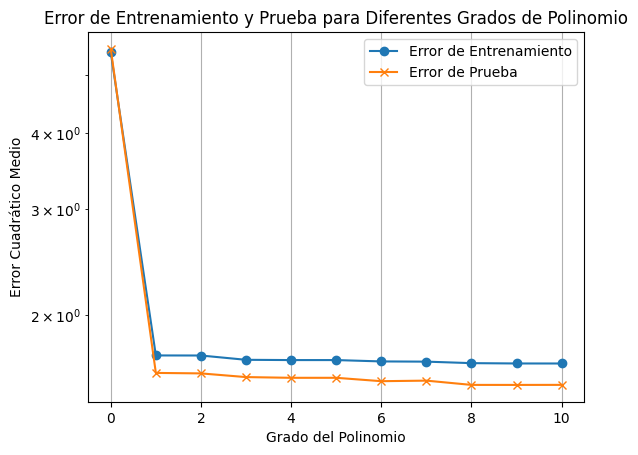

In [16]:
# Dividir los datos en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(r, m, test_size=0.2, random_state=42)

# Verificar las dimensiones de los conjuntos de datos
print(f'Dimensiones del conjunto de entrenamiento: {x_train.shape}')
print(f'Dimensiones del conjunto de prueba: {x_test.shape}')

# Inicializar listas para almacenar los errores de entrenamiento y prueba
error_train = []
error_test = []

# Ajustar polinomios de grado 0 a 10 y calcular los errores
for degree in range(11):
    # Ajustar el polinomio y obtener sus parámetros
    coefficients = np.polyfit(x_train, y_train, degree)
    polynomial = np.poly1d(coefficients)  # Crear el polinomio a partir de los parámetros

    # Calcular el error cuadrático medio para el conjunto de entrenamiento
    error_train.append(np.mean((polynomial(x_train) - y_train) ** 2))

    # Calcular el error cuadrático medio para el conjunto de prueba
    error_test.append(np.mean((polynomial(x_test) - y_test) ** 2))

# Graficar los errores de entrenamiento y prueba
plt.plot(error_train, label='Error de Entrenamiento', marker='o')
plt.plot(error_test, label='Error de Prueba', marker='x')
plt.legend()
plt.xlabel('Grado del Polinomio')
plt.ylabel('Error Cuadrático Medio')
plt.title('Error de Entrenamiento y Prueba para Diferentes Grados de Polinomio')
plt.semilogy()  # Usar escala logarítmica para el eje y
plt.grid()
plt.show()
